# QMSS G5072 Homework 5
## Exercise 1. Engine Incidents and Failures
### a) Extracting Engine Incidents


In [3]:
#load data
import pandas as pd
import re
import matplotlib.pyplot as plt
import random
ntsb = pd.read_csv('ntsb_narratives_2021_2024.csv')

In [5]:
ntsb
#look the data

,ev_id,year,narrative
0,20080219X00203,2022,During a cross country flight the pilot of a C...
1,20080514X00667,2024,This incident occurred when United Airlines fl...
2,20080416X00494,2022,"The pilot planed a flight from Frederick, Mary..."
3,20080213X00186,2022,"While on climb out from the airport, the pilot..."
4,20080222X00229,2024,go! flight 1002 departed for its destination a...
...,...,...,...
5904,20240805194841,2024,The student pilot reported that while landing ...
5905,20240817194942,2024,"According to the flight instructor, the wind w..."
5906,20240820194969,2024,The pilot reported flying a normal approach an...
5907,20240821194973,2024,"Before the landing, the pilot told the flight ..."


In [7]:
# Create a column 'engine' that marks incidents containing the word "engine" or "engines" 
ntsb['engine'] = ntsb['narrative'].str.contains(r'\bengine(?:s)?\b', case=False, regex=True)
#Count the number
engine_related_count = ntsb['engine'].sum()
print("Number of engine-related incidents:", engine_related_count)

Number of engine-related incidents: 2940


### b) Use regular expressions to specifically extract narratives that describe engine failures, differentiating them from general engine incidents.

In [9]:
failure_pattern = r'\b(?:\w+\s)?(?:\w+\s)?engine(?:s)?\s(?:failure|failed|stopped|lost|shutdown|quit)\b|\b(?:failure|failed|stopped|lost|shutdown|quit)\sengine(?:s)?\b'

# Create a boolean column 'engine_failure'
ntsb['engine_failure'] = ntsb['narrative'].str.contains(failure_pattern, case=False, regex=True)
# Summary data
total_narratives = len(ntsb)
engine_mentions = ntsb['engine'].sum()
engine_failures = ntsb['engine_failure'].sum()
# Calculate proportions
engine_mention_proportion = engine_mentions / total_narratives
failure_proportion = engine_failures / engine_mentions if engine_mentions > 0 else 0
# show results
print(f"Total narratives: {total_narratives}")
print(f"Number of narratives mentioning 'engine': {engine_mentions}")
print(f"Proportion of narratives mentioning 'engine': {engine_mention_proportion:.2%}")
print(f"Number of narratives identified as engine failures: {engine_failures}")
print(f"Proportion of engine mentions identified as failures: {failure_proportion:.2%}")

Total narratives: 5909
Number of narratives mentioning 'engine': 2940
Proportion of narratives mentioning 'engine': 49.75%
Number of narratives identified as engine failures: 770
Proportion of engine mentions identified as failures: 26.19%


### c) Randomly select 10 entries from the dataset. Display the portion of the narratives with the 2 words before and after the mention of engine, alongside your two new variables engine and engine_failure. Briefly discuss how this identification process could be improved. Mention potential issues with false positives or missed entries

In [18]:
#random select
sample_entries = ntsb[ntsb['engine']].sample(10, random_state=1)

def extract_context(text):
    match = re.search(r'(\b\w+\b\s){0,2}engine(s)?(\s\b\w+\b){0,2}', text, re.IGNORECASE)
    if match:
        return match.group(0).strip()
    return "No context found"
# Apply the function to get the context for each sampled narrative
sample_entries['engine_context'] = sample_entries['narrative'].apply(extract_context)
# Select relevant columns 
display_columns = sample_entries[['narrative', 'engine_context', 'engine', 'engine_failure']]
# Display the DataFrame with the selected entries
display_columns


,narrative,engine_context,engine,engine_failure
2114,The airplane owner reported that the accident ...,and the engine was running,True,False
5192,The pilot reported that before his 12th aerial...,and the engine separated from,True,False
5169,The pilot and the flight instructor were perfo...,engine airplane,True,False
3679,The pilot and pilot-rated passenger completed ...,of the engine and engine,True,False
574,While conducting takeoffs and landings during ...,the engine began to,True,False
4693,The solo student pilot reported that he landed...,The engine mount was,True,False
4902,The flight instructor reported that prior to h...,of the engine cowling opened,True,False
5653,The airplane’s engine momentarily lost power w...,s engine momentarily lost,True,False
1644,The pilot-rated passenger reported that before...,performed an engine run,True,True
2131,"The pilot of the experimental, amateur-built a...",when the engine momentarily lost,True,True


In [17]:
# answer
print(f"our method have some problem like it only consider simple pattern, some failure incidents without explicit terms such as stoped or using abbreviations will missing by using our ways. We can make some improvement by consider more situation like expanding the list of keywords of failure event and have a detail llok at the data. ")

our method have some problem like it only consider simple pattern, some failure incidents without explicit terms such as stoped or using abbreviations will missing by using our ways. We can make some improvement by consider more situation like expanding the list of keywords of failure event and have a detail llok at the data. 


## 2. Extracting the Time of Day
### a) Use regular expressions to extract the time of day from the narratives. 

In [22]:
# time_pattern consider am/pm,pattern
time_pattern = r'\b((1[0-2]|0?[1-9]):([0-5][0-9])\s?(AM|PM)|([01]?[0-9]|2[0-3])[0-5][0-9]|([01]?[0-9]|2[0-3]):([0-5][0-9]))\b'

# Function convert captured time to a 24-hour format string
def extract_time(text):
    match = re.search(time_pattern, text, re.IGNORECASE)
    if match:
        if match.group(4):  # If AM/PM is present
            hour, minute, period = int(match.group(2)), match.group(3), match.group(4).upper()
            if period == 'PM' and hour != 12:
                hour += 12
            elif period == 'AM' and hour == 12:
                hour = 0
            return f"{hour:02}:{minute}"
        elif match.group(5):  # If 24-hour format like 0940 is present
            hour, minute = match.group(5)[:2], match.group(5)[-2:]
            return f"{int(hour):02}:{minute}"
        elif match.group(6):  # If 24-hour format with colon like 14:30 is present
            return f"{int(match.group(6)):02}:{match.group(7)}"
    return ""

# create a new column 'time_of_day'
ntsb['time_of_day'] = ntsb['narrative'].apply(extract_time)

# Display the first 5 entries where 'time_of_day' is successfully extracted
time_extracted_entries = ntsb[ntsb['time_of_day'] != ""].head(5)
print(time_extracted_entries[['narrative', 'time_of_day']])

# Summary data on how many narratives contain a time mention
time_mention_count = ntsb['time_of_day'].apply(lambda x: x != "").sum()
total_narratives = len(ntsb)
time_mention_proportion = time_mention_count / total_narratives

print(f"Number of narratives with time mentioned: {time_mention_count}")
print(f"Proportion of narratives with time mentioned: {time_mention_proportion:.2%}")

                                           narrative time_of_day
0  During a cross country flight the pilot of a C...        00:0
1  This incident occurred when United Airlines fl...        07:7
4  go! flight 1002 departed for its destination a...       10:10
5  ** This report was modified on July 5, 2023. P...       20:20
6  The pilot was asked by a ferry company represe...        00:0
Number of narratives with time mentioned: 2137
Proportion of narratives with time mentioned: 36.17%


### b) Analyze the relationship between time of day and engine failures. Create a bar plot where the x-axis represents the hour of day and the y-axis represents the proportion of engine failures (as a share of all mentions of the aircraft model). Comment briefly on what you found.


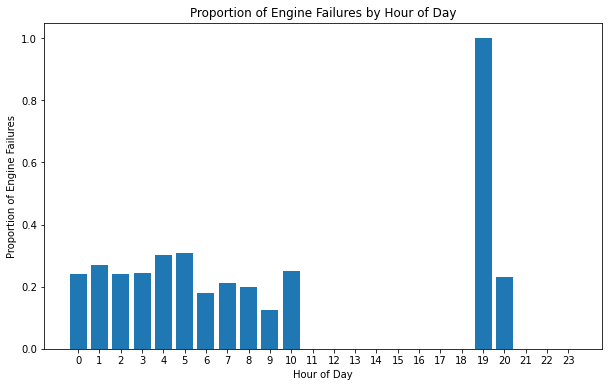

In [23]:
# Extract the hour from the 'time_of_day' column
ntsb['hour_of_day'] = ntsb['time_of_day'].apply(lambda x: int(x.split(':')[0]) if x else None)

# Filter only entries with a valid hour
ntsb_with_hour = ntsb[ntsb['hour_of_day'].notna()]

# Group by hour, calculate the proportion of engine failures
hourly_data = ntsb_with_hour.groupby('hour_of_day').apply(
    lambda x: x['engine_failure'].sum() / x['engine'].sum() if x['engine'].sum() > 0 else 0
).reset_index(name='failure_proportion')

# Plot data
plt.figure(figsize=(10, 6))
plt.bar(hourly_data['hour_of_day'], hourly_data['failure_proportion'], width=0.8)
plt.xlabel('Hour of Day')
plt.ylabel('Proportion of Engine Failures')
plt.title('Proportion of Engine Failures by Hour of Day')
plt.xticks(range(0, 24))  # Set x-axis to show each hour
plt.show()

###### 19:00 hours have highest failure proportions, potentially indicating this times failures happened frequently may due to several factor like weather or use frequenly.
###### in the afternoon is tend to have a lower proportions, which could reflect times of less activity or reduced operational stress on engines.

### 3. Identifying Aircraft Models for a Common Manufacturer

#### a)

In [26]:

manufacturers = ['Cessna', 'Piper', 'Beechcraft', 'Boeing', 'Airbus', 'Cirrus', 'Robinson', 'Embraer', 'Bombardier', 'Mooney']

# Create a regex pattern to match any of the manufacturers
manufacturer_pattern = r'\b(' + '|'.join(manufacturers) + r')\b'

# Function to identify the manufacturer in each narrative
def find_manufacturer(text):
    match = re.search(manufacturer_pattern, text, re.IGNORECASE)
    return match.group(1) if match else ""

# create a new column 'manufacturer'
ntsb['manufacturer'] = ntsb['narrative'].apply(find_manufacturer)

# Filter only entries where a manufacturer was identified
manufacturer_df = ntsb[ntsb['manufacturer'] != ""]

# Count mentions and calculate share of engine failures for each manufacturer
manufacturer_stats = manufacturer_df.groupby('manufacturer').apply(
    lambda x: pd.Series({
        'mentions': len(x),                                          
        'engine_failure_share': x['engine_failure'].sum() / len(x)   
    })
).reset_index()

# Display the table of manufacturer mentions and engine failure share
print("Manufacturer Mentions and Engine Failure Share:")
print(manufacturer_stats)

Manufacturer Mentions and Engine Failure Share:
  manufacturer  mentions  engine_failure_share
0       Airbus      36.0              0.055556
1   Beechcraft       2.0              0.000000
2       Boeing      70.0              0.057143
3   Bombardier       9.0              0.000000
4       Cessna      51.0              0.058824
5       Cirrus      11.0              0.000000
6      Embraer      16.0              0.000000
7       Mooney       6.0              0.166667
8        Piper      20.0              0.050000
9     Robinson       1.0              0.000000


#### b)

In [29]:
most_common_manufacturer = manufacturer_stats.loc[manufacturer_stats['mentions'].idxmax(), 'manufacturer']
print(f"The most common manufacturer identified: {most_common_manufacturer}")

# Define regex pattern for extracting models related to the most common manufacturer
# This pattern captures variations like "Cessna 172", "Cessna-172", "172 Cessna"
model_pattern = rf'\b({most_common_manufacturer})[\s-]?(\w+\d+)|(\w+\d+)[\s-]?({most_common_manufacturer})\b'

# Function to extract the model for the most common manufacturer
def extract_model(text):
    match = re.search(model_pattern, text, re.IGNORECASE)
    if match:
        # Capture the model based on whether it appears before or after the manufacturer name
        return match.group(2) if match.group(2) else match.group(3)
    return ""

# Apply the function to create a new column 'specific_model' for the extracted models
ntsb['specific_model'] = ntsb['narrative'].apply(extract_model)

# Filter dataset to entries with identified models of the most common manufacturer
models_df = ntsb[(ntsb['manufacturer'] == most_common_manufacturer) & (ntsb['specific_model'] != "")]

# Calculate statistics for each model of the most common manufacturer
model_stats = models_df.groupby('specific_model').apply(
    lambda x: pd.Series({
        'model_mentions': len(x),                                       
        'engine_related_share': x['engine'].sum() / len(x),             #
        'engine_failure_share': x['engine_failure'].sum() / x['engine'].sum() if x['engine'].sum() > 0 else 0  # Share of engine failures
    })
).reset_index()


print(model_stats)

The most common manufacturer identified: Boeing
  specific_model  model_mentions  engine_related_share  engine_failure_share
0            737            27.0              0.185185                  0.40
1            747             2.0              0.000000                  0.00
2            757            10.0              0.200000                  0.00
3            767             5.0              0.800000                  0.25
4            777             8.0              0.500000                  0.25
5            787             3.0              0.000000                  0.00
6           B737             3.0              0.000000                  0.00
7           B747             1.0              1.000000                  0.00
8           B767             1.0              0.000000                  0.00
9           B777             1.0              0.000000                  0.00
